In [1]:
import reeds_shepp
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import dubins
from spline_math import *
from obstacle_maneuvre import *
import pandas as pd
import sys
import os
%matplotlib notebook
%matplotlib inline 
%matplotlib qt 



In [2]:
sys.path.append(os.getcwd() + "/ReedsSheppPath")
sys.path.append(os.getcwd() + "/HybridAStar")

try:
    from dynamic_programming_heuristic import calc_distance_heuristic
    import reeds_shepp_path_planning as rs
    from car import move, check_car_collision, MAX_STEER, WB, plot_car
    from hybrid_a_star import *
except Exception:
    raise


In [13]:
start_x = -24.3583; 
start_y =  12.2977
start_yaw =  2.54654 

goal_x =  -25.1548  
goal_y = 14.618;
goal_yaw =2.69509

max_curv = np.tan(0.6)/0.75
paths = rs.calc_paths(start_x, start_y, start_yaw,
                  goal_x, goal_y, goal_yaw,
                  2, step_size=0.1)


In [14]:
for path in paths:
    print(path.ctypes)
    print(path.lengths)

['S', 'L', 'S']
[11.779242685855362, 0.07427500000000009, -10.003166036743274]
['R', 'S', 'L']
[0.3944925725665298, 1.6699725942111936, 0.4687675725665299]


In [15]:
path.yaw

[2.5465400000000002,
 2.346539999999999,
 2.14654,
 1.9465399999999997,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.7575548548669406,
 1.95755485486694,
 2.15755485486694,
 2.3575548548669403,
 2.5575548548669405,
 2.6950900000000004]

In [50]:
arc_l = XY_GRID_RESOLUTION * 1.5
x_list, y_list, yaw_list = [], [], []

for _ in np.arange(0, arc_l, MOTION_RESOLUTION):
    print(_)

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001


In [51]:


df = pd.read_csv (os.getcwd()+"/surf_waypoints/car3.csv")   #read the csv file (put 'r' before the path string to address any special characters in the path, such as '\'). Don't forget to put the file name at the end of the path + ".csv"
print (df)
x_line = df["x"].to_numpy() 
y_line = df["y"].to_numpy() 
z_line = df["z"].to_numpy() 

y_line+=20
x_line+=50

set_initial = np.hstack((x_line[:, np.newaxis], y_line[:, np.newaxis], 0*z_line[:, np.newaxis]))
spline = M_spline_from_set(set_initial)



min_obstcle_avoid_radius = 1.0
max_turning_radius = 2.0
curr_spline_index = 3
max_serching_distanse = 20

          x       y      z
0    -6.089  13.049 -2.919
1    -6.767  12.958 -2.903
2    -7.404  12.872 -2.888
3    -8.044  12.786 -2.873
4    -8.688  12.700 -2.857
..      ...     ...    ...
155 -27.731  16.941 -2.517
156 -28.308  17.218 -2.505
157 -28.884  17.495 -2.493
158 -29.460  17.772 -2.481
159 -30.245  18.149 -2.466

[160 rows x 3 columns]


In [52]:
from math import cos, sin
def plot_2d(x_line, y_line):
    fig = plt.figure(figsize = (20,20))
    ax = plt.axes()
    ax.plot(x_line, y_line, 'gray')
    ax.scatter(x_line, y_line, cmap='Greens')
    
def plot_3d(x_line, y_line, z_line):
    fig = plt.figure(figsize = (20,20))
    ax = plt.axes(projection='3d')
    ax.plot3D(x_line, y_line, z_line, 'gray')
    ax.scatter3D(x_line, y_line, z_line, cmap='Greens')
    
def draw_obstacles(ax, obstcl_arr, min_obstcle_avoid_radius, color = 'g'):
    for obstc in obstcl_arr:
        ax.scatter(obstc[0], obstc[1],c = 'k')
        circle1 = plt.Circle((obstc[0], obstc[1]), min_obstcle_avoid_radius, color=color, fill=False)
        ax.add_patch(circle1)


def make_points_from_relative_data(obsracl_realt_list, spline_cfg):
    theta  = np.pi/2
    rot = np.array([[0, -sin(theta), 0 ], [sin(theta), cos(theta), 0],  [0, 0, 1]])
    x0 = spline_point(spline_cfg, 0)
    mov_dir = spline_point_derv(spline_cfg,0)
    dir1_ortgn = np.dot(rot, mov_dir)
    
    mov_dir = mov_dir/np.linalg.norm(mov_dir)
    dir1_ortgn = dir1_ortgn/np.linalg.norm(dir1_ortgn)
    
    
    obstacles_abs = []
    #print(np.linalg.norm(dir1_ortgn))
    #print(np.linalg.norm(mov_dir))
    #print(dir1_ortgn)
    #print(mov_dir)
    for point in obsracl_realt_list:
        #print(point)
        x_new = x0 + point[1]*dir1_ortgn + point[0]*mov_dir
        obstacles_abs.append((x_new[0],x_new[1], 0))
        
    return  obstacles_abs

def make_curve_elem(path):
    c_types = []
    yaw = path.yaw_list
    for ii in range(len(yaw)-1):
        if(path.direction_list[ii+1] == True):
            d = 1
        else:
            d = -1   

        if(abs(yaw[ii+1] - yaw[ii])<0.000001):
            c_types.append((d, "S"))        
        elif( yaw[ii+1]*yaw[ii] < 0):      
            c_types.append(c_types[-1])       
        elif((yaw[ii+1]) > (yaw[ii])):     
            if(d==1):
                mark = "L"
            else:
                mark = "R"                  
            c_types.append((d, mark))           
        elif((yaw[ii+1]) < (yaw[ii])):
            if(d==1):
                mark = "R"
            else:
                mark = "L"               
            c_types.append((d, mark) )

    lenth_cur = 0
    curve_types = []
    points_ind = []
    
    for ii in range(len(c_types)-1):
        if(c_types[ii] == c_types[ii+1]):
            lenth_cur += 0.1*c_types[ii][0]
        else:
            lenth_cur += 0.1*c_types[ii][0]
            curve_types.append((round(lenth_cur,2), c_types[ii][1]))
            lenth_cur = 0
            points_ind.append(ii+1)
    
    last_ind = len(c_types) - 1
    if(c_types[last_ind] == c_types[last_ind-1]):                
        #print("yes",lenth_cur, c_types[last_ind], curve_types[-1])
        #del curve_types[-1]    
        curve_types.append((round(0.1*c_types[last_ind][0]+lenth_cur, 2), c_types[last_ind][1]))         
    else:
        #print("no")
        curve_types.append((round(0.1*c_types[last_ind][0], 2), c_types[last_ind][1]))  
        
    points_ind.append(last_ind+1)
    
    return curve_types, c_types, points_ind

<IPython.core.display.Javascript object>


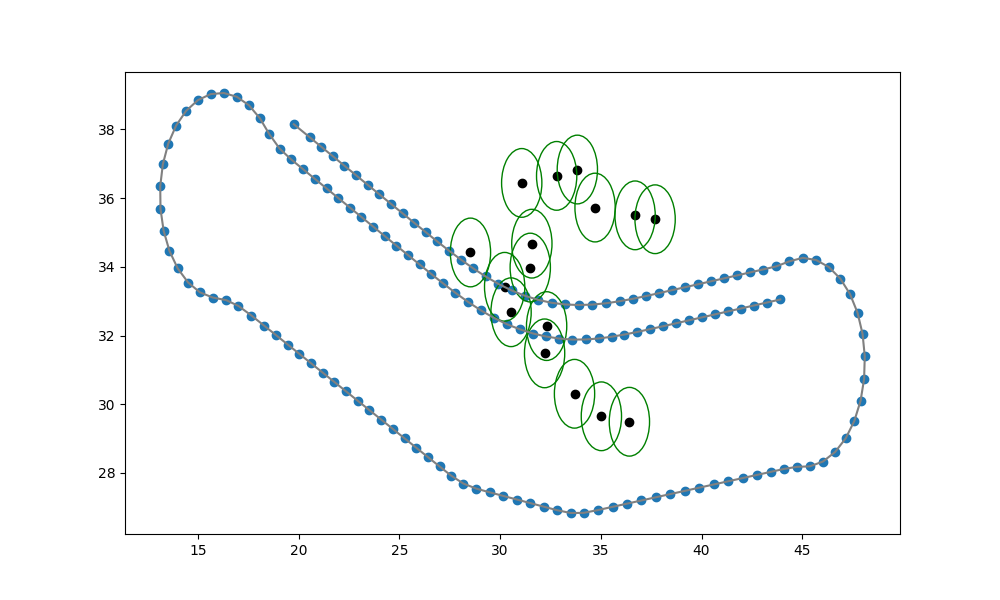

In [53]:

obstacles_full = make_points_from_relative_data([(0.01, 0.5, 0),
                                            #(3.1, -0.8),
                                            (1.0,-1.9),
                                             (1.0, -2.6),
                                             (-1.0, -5.0),
                                             (-2,-4),
                                             (0, -4.7),
                                              #(2,-4),
                                            (4,-2),
                                           (0,-0.3),
                                          (-1.6,1.5),
                                           (-3,2),
                                           (-5,-4),
                                           (1.7,-4.3),
                                           ( -4, -4),
                                            (-4.4,2),
                                            (2.2,-1.2),
                                            (1.8,-0.5),
                                           ], spline[18])

obstacles_full = obstacles_full[:]
obstacles_full = np.array(obstacles_full)
fig = plt.figure(figsize = (10,6))
ax = plt.axes()

draw_obstacles(ax, obstacles_full, min_obstcle_avoid_radius)
ax.plot(x_line, y_line, 'gray')
ax.scatter(x_line, y_line, cmap='Greens')



In [93]:
def make_obstacle_tree(obstacles_full, visible_radius, start):
    ox, oy = [], []
    for obstcl in obstacles_full:
        ox.append(obstcl[0])
        oy.append(obstcl[1])
    tox, toy = ox[:], oy[:]
    obstacle_kd_tree = cKDTree(np.vstack((tox, toy)).T)
    indexes = obstacle_kd_tree.query_ball_point(start[:2],visible_radius)
    obstacles = [obstacles_full[ind] for ind in indexes]
    ox, oy = [], []
    for obstcl in obstacles:
        ox.append(obstcl[0])
        oy.append(obstcl[1])
    tox, toy = ox[:], oy[:]
    obstacle_kd_tree = cKDTree(np.vstack((tox, toy)).T)
    return obstacles, obstacle_kd_tree

start :  [-18.5, 16, 1.9198621771937625]


<IPython.core.display.Javascript object>


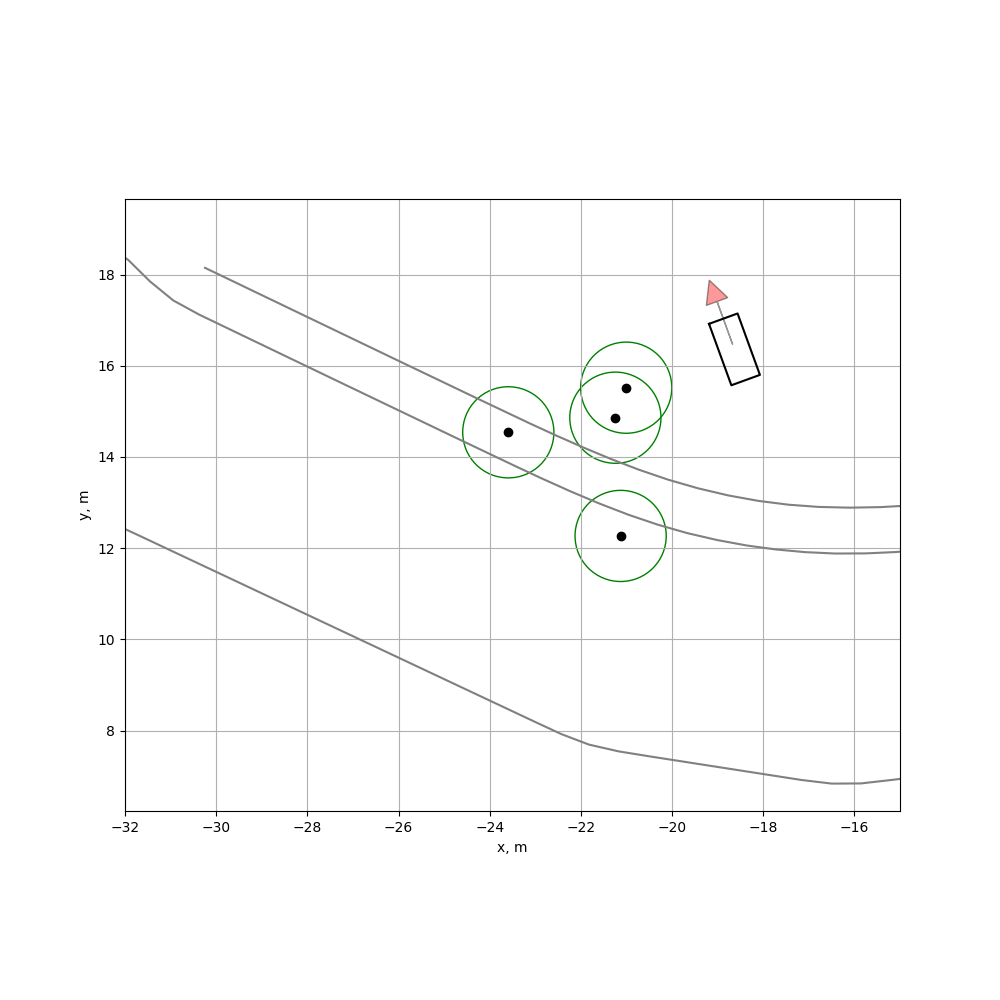

In [95]:

df = pd.read_csv (os.getcwd()+"/surf_waypoints/car3.csv") 

x_line = df["x"].to_numpy() 
y_line = df["y"].to_numpy() 
z_line = df["z"].to_numpy()

set_initial = np.hstack((x_line[:, np.newaxis], y_line[:, np.newaxis], 0*z_line[:, np.newaxis]))
spline = M_spline_from_set(set_initial)

obstacles_full = make_points_from_relative_data([(0.01, 0.5, 0),
                                                        (3.1, -0.8),
                                                        (1.0,-1.9),
                                                        (1.0, -2.6),
                                                        (-1.0, -5.0),
                                                        (-2,-4),
                                                        (0, -4.7),
                                                        (2,-4),
                                                        (4,-2),
                                                        (0,-0.3),
                                                        (-1.6,1.5),
                                                        (-3,2),
                                                        (-5,-4),
                                                        (1.7,-4.3),
                                                        ( -4, -4),
                                                        (-4.4,2),
                                                        (2.2,-1.2),
                                                        (1.8,-0.5)
                                                        ], 
                                                        spline[23])

# Set Initial parameters
start = [-18.5, 16, np.deg2rad(110.0)]


print("start : ", start)

show_animation = False
fig = plt.figure(figsize = (10,10))
ax = plt.axes()

draw_obstacles(ax, obstacles_full[:4], min_obstcle_avoid_radius)
ax.plot(x_line, y_line, 'gray')

plt.grid(True)

plot_car(start[0], start[1], start[2])

plt.xlabel("x, m")
plt.ylabel("y, m")
plt.xlim(-32,-15)
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()
plt.show()


True
pos obstcl: (-22.471548424927153, 13.816882847153035, 0)
ind: 25
s*: 0.6853976428209764
p: [-22.64447933  13.43354431   0.        ]
dp: [-0.61519845  0.27752707  0.        ]
Delta: [0.1729309  0.38333854 0.        ]
delta: 0.42053957099457173
dist to obstc: 16.188285182042968
True
pos obstcl: (-23.592179090998435, 14.540890381824212, 0)
ind: 27
s*: 0.7378581918852324
p: [-23.85130839  13.99557219   0.        ]
dp: [-0.57558145  0.27351008  0.        ]
Delta: [0.2591293  0.54531819 0.        ]
delta: 0.6037548515023382
dist to obstc: 17.5195799514816
True
pos obstcl: (-21.128020890761338, 12.268001391089232, 0)
ind: 23
s*: 0.014369430249977442
p: [-20.95779105  12.73813411   0.        ]
dp: [-0.63497167  0.2299162   0.        ]
Delta: [-0.17022984 -0.47013272  0.        ]
delta: -0.5000029710666056
dist to obstc: 14.36348245784543
goal index is 27
start :  [-16.5, 12, 2.9670597283903604]


<IPython.core.display.Javascript object>


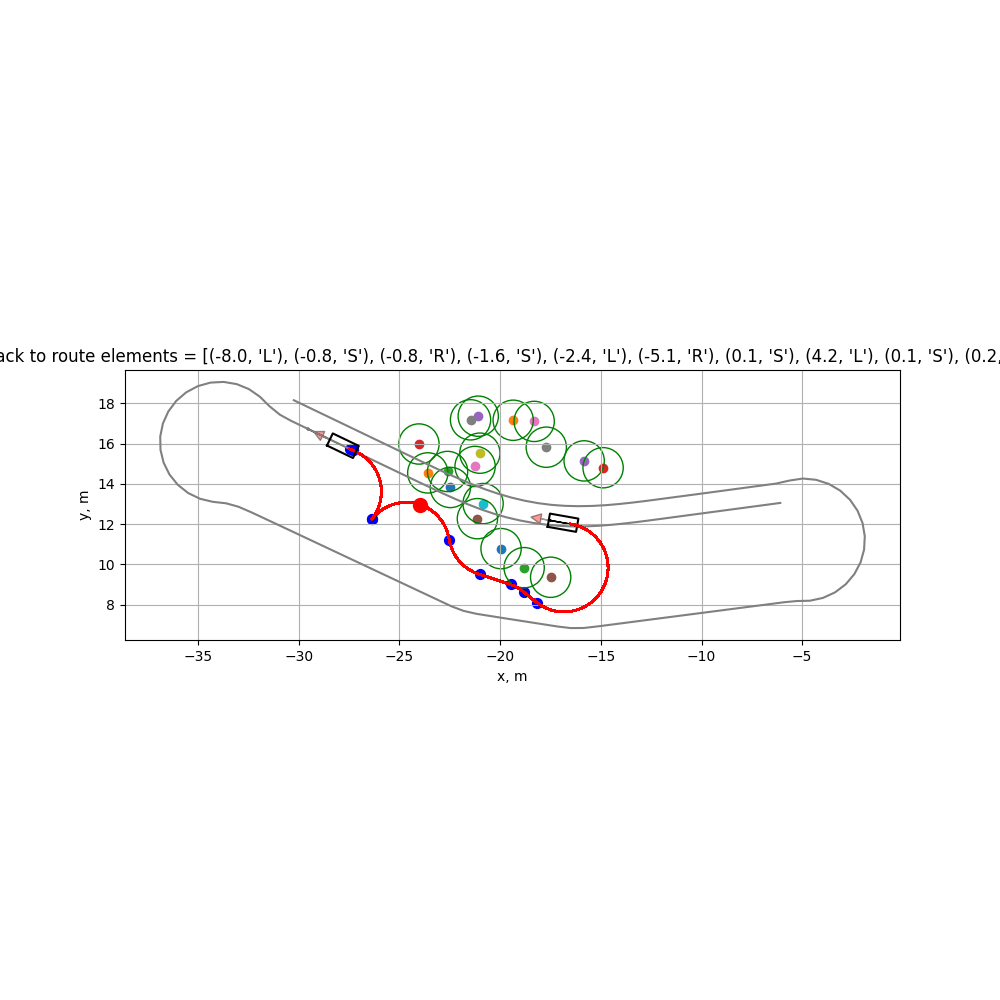

min x -63 min y -6 min yaw -36
max x -3 max y 54 max yaw 36
x_w 60 y_w 60 yaw_w 72
your near goal
path found
n_iter = 787, len close = 416, len open = 639
 plot!!
 done!!
back to route elements = [(-8.0, 'L'), (-0.8, 'S'), (-0.8, 'R'), (-1.6, 'S'), (-2.4, 'L'), (-5.1, 'R'), (0.1, 'S'), (4.2, 'L'), (0.1, 'S'), (0.2, 'R')]


In [81]:

df = pd.read_csv (os.getcwd()+"/surf_waypoints/car3.csv") 

x_line = df["x"].to_numpy() 
y_line = df["y"].to_numpy() 
z_line = df["z"].to_numpy()

set_initial = np.hstack((x_line[:, np.newaxis], y_line[:, np.newaxis], 0*z_line[:, np.newaxis]))
spline = M_spline_from_set(set_initial)

obstacles_full = make_points_from_relative_data([(0.01, 0.5, 0),
                                                        (3.1, -0.8),
                                                        (1.0,-1.9),
                                                        (1.0, -2.6),
                                                        (-1.0, -5.0),
                                                        (-2,-4),
                                                        (0, -4.7),
                                                        (2,-4),
                                                        (4,-2),
                                                        (0,-0.3),
                                                        (-1.6,1.5),
                                                        (-3,2),
                                                        (-5,-4),
                                                        (1.7,-4.3),
                                                        ( -4, -4),
                                                        (-4.4,2),
                                                        (2.2,-1.2),
                                                        (1.8,-0.5)
                                                        ], 
                                                        spline[23])
                  
min_obstcle_avoid_radius = 1.0
curr_spline_index = 3
max_serching_distanse = 20
visible_radius = 10.5

# Set Initial parameters
start = [-16.5, 12, np.deg2rad(170.0)]
border_size = 15
border = [ [start[0] - border_size , start[0] + border_size], [ start[1] - border_size, start[1] + border_size ] ]
obstacles, obstacle_kd_tree =  make_obstacle_tree(obstacles_full, visible_radius, start)
start_ind = 1
max_dist = 50
cr_arr = []

for obtcl in obstacles:
    cr = find_control_params(start_ind, max_dist, spline, obtcl)
    if((cr.ok) and abs(cr.delta)<=1):
        cr.print_all()
        #cr_arr.append(cr)

cr_arr.sort()
goal_spline_ind = 20 ##??
if(cr_arr !=[]):
    goal_spline_ind = cr_arr[-1].cfs_index
print(f"goal index is {goal_spline_ind}")
search_ares = [list(spline_find_point_state2d(spline[goal_spline_ind + ind], 0)) for ind in range(3,10)] 
#cr_arr[-1].print_all()


print("start : ", start)

show_animation = False
fig = plt.figure(figsize = (10,10))
ax = plt.axes()

draw_obstacles(ax, obstacles, min_obstcle_avoid_radius)
ax.plot(x_line, y_line, 'gray')


goal = search_ares[-1]
#plt.plot(ox, oy, ".k")
rs.plot_arrow(start[0], start[1], start[2])
rs.plot_arrow(goal[0], goal[1], goal[2])

plt.grid(True)

(path, path_rs_final) = hybrid_a_star_planning(
    start, search_ares, goal_spline_ind, border, obstacle_kd_tree, XY_GRID_RESOLUTION, YAW_GRID_RESOLUTION, spline, min_obstcle_avoid_radius, _show_animation_ = show_animation)

path = path[0]
x = np.array(path.x_list[:])
y = np.array(path.y_list[:])
yaw = np.array(path.yaw_list[:])


print(" plot!!")
for ii, (i_x, i_y, i_yaw) in enumerate(zip(x, y, yaw)):
    if(ii==0):
        plot_car(i_x, i_y, i_yaw)
    #plt.cla()
    plt.plot(x, y, "-r", label="Hybrid A* path")
    plt.grid(True)
    #plt.axis("equal")
    #
    #plt.pause(0.0001)
plot_car(i_x, i_y, i_yaw)

print(" done!!")
bact_to_route_elements, _ , elem_p_ind = make_curve_elem(path)
print(f"back to route elements = {bact_to_route_elements}")
#print(path_rs_final.lengths)
#print(path_rs_final.ctypes)
#print(path_rs_final.x[0], path_rs_final.y[0], path_rs_final.yaw[0])
#print(path_rs_final.x[-1], path_rs_final.y[-1], path_rs_final.yaw[-1])

plt.scatter(path_rs_final.x[0], path_rs_final.y[0], c='r',s = 100)
plt.scatter(x[elem_p_ind], y[elem_p_ind], c='b',s = 50)
plt.title(f"Back to route elements = {bact_to_route_elements}")
plt.xlabel("x, m")
plt.ylabel("y, m")
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()
plt.show()


<IPython.core.display.Javascript object>


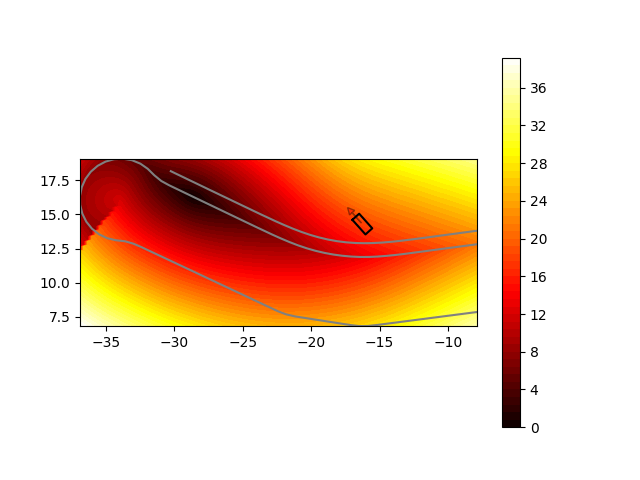

In [65]:

def make_heuvristic_potential(goal,x,y):
    potential = np.zeros((len(x),len(y))) 
    x_c = goal[0]
    y_c = goal[1]
    for ii in range(len(x)):
        for jj in range(len(y)):
            X = x[ii]
            Y = y[jj]
            cr = find_control_params(1,60,spline,(X,Y,0))
            if(cr.ok == True):
                traj_dist = abs(cr.delta)
                #print("ok")
            else:
                traj_dist = 0
            dist_evkl = np.sqrt((X-x_c)**2 +(Y-y_c)**2)
            potential[jj][ii] = 2.2*traj_dist + dist_evkl            
    return potential

fig = plt.figure()
x = np.linspace(x_line.min(), x_line.max()-6, 100)
y = np.linspace(y_line.min(), y_line.max(), 100)
#draw_obstacles(ax, obstacles_full[:6], min_obstcle_avoid_radius)
plt.plot(x_line, y_line, 'gray')
plt.scatter(x_line, y_line, cmap='Greens')
Z_heuvr = make_heuvristic_potential(search_ares[-1],x,y)
cs = plt.contourf(x, y, Z_heuvr, levels=np.arange(0, Z.max(), 0.8),  cmap="hot") 
cbar = fig.colorbar(cs, orientation='vertical')
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())
plot_car(-16, 14, 40)
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()


<IPython.core.display.Javascript object>


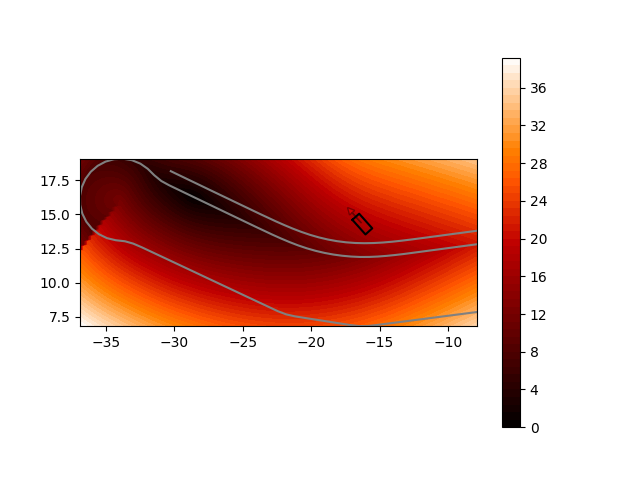

In [76]:
fig = plt.figure()
x = np.linspace(x_line.min(), x_line.max()-6, 100)
y = np.linspace(y_line.min(), y_line.max(), 100)
#draw_obstacles(ax, obstacles_full[:6], min_obstcle_avoid_radius)
plt.plot(x_line, y_line, 'gray')
plt.scatter(x_line, y_line, cmap='Greens')

cs = plt.contourf(x, y, Z, levels=np.arange(0, Z.max(), 0.8),  cmap="gist_heat") 
cbar = fig.colorbar(cs, orientation='vertical')
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())
plot_car(-16, 14, 40)
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()


In [71]:
np.hstack([np.arange(0, Z.max()/2,0.01),np.arange(Z.max()/2, Z.max()/2,0.1)])

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 1.962e+01, 1.963e+01,
       1.964e+01])

In [74]:
np.arange(1,2,0.1)

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])

In [50]:
Z[:30,:30].max()

56.568542494923804

In [54]:

paths = rs.calc_paths(path_rs_final.x[0], path_rs_final.y[0], path_rs_final.yaw[0], 
             path_rs_final.x[-1], path_rs_final.y[-1], path_rs_final.yaw[-1],0.5, 0.1)

draw_obstacles(ax, obstacles, min_obstcle_avoid_radius)
ax.plot(x_line, y_line, 'gray')
ax.scatter(x_line, y_line, cmap='Greens')
for obstcl in obstacles:
    ox.append(obstcl[0])
    oy.append(obstcl[1])

fig = plt.figure()
if show_animation:
    plt.plot(ox, oy, ".k")
    rs.plot_arrow(start[0], start[1], start[2], fc='g')
    rs.plot_arrow(goal[0], goal[1], goal[2])

    plt.grid(True)
    plt.axis("equal")

ax = plt.axes()

draw_obstacles(ax, obstacles, min_obstcle_avoid_radius)
ax.plot(x_line, y_line, 'gray')
ax.scatter(x_line, y_line, cmap='Greens')


for path in paths:
    x = path.x
    y = path.y
    yaw = path.yaw


    if show_animation:

        for ii, (i_x, i_y, i_yaw) in enumerate(zip(x, y, yaw)):
            if(ii==0):
                plot_car(i_x, i_y, i_yaw)
            #plt.cla()
            plt.plot(ox, oy, ".k")
            plt.plot(x, y, "-r", label="Hybrid A* path")
            plt.grid(True)
            plt.axis("equal")
            #
            plt.pause(0.0001)
        plot_car(i_x, i_y, i_yaw)


NameError: name 'path_rs_final' is not defined

In [32]:
print(path_rs_final.lengths)
print(path_rs_final.ctypes)
print(path_rs_final.x[0], path_rs_final.y[0], path_rs_final.yaw[0])
print(path_rs_final.x[-1], path_rs_final.y[-1], path_rs_final.yaw[-1])

[-6.522766734535448, -2.9779511326640495, 4.856139096817175]
['L', 'R', 'L']
40.79261863883651 33.018897590838044 2.56787638414122
34.24316666666667 31.889333333333326 -3.1172258093479144


In [30]:
path.direction_list

[True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [62]:
ox, oy = [], []


for i in range(60):
    ox.append(i)
    oy.append(0.0)
for i in range(60):
    ox.append(60.0)
    oy.append(i)
for i in range(61):
    ox.append(i)
    oy.append(60.0)
for i in range(61):
    ox.append(0.0)
    oy.append(i)

obstacles = make_points_from_relative_data([(0.01, -0.1, 0),
                                             (2.2, 0.2),
                                              (1.0,-1.9),
                                              (0.)], spline[10])
# Set Initial parameters
start = [3.0, 30.0, np.deg2rad(90.0)]
goal = [50.0, 35.0, np.deg2rad(-90.0)]

start = list(spline_find_point_state2d(spline[3],0))
goal = list(spline_find_point_state2d(spline[20],0))

print("start : ", start)
print("goal : ", goal)

fig = plt.figure()
ax = plt.axes()

draw_obstacles(ax, obstacles, min_obstcle_avoid_radius)
ax.plot(x_line, y_line, 'gray')
ax.scatter(x_line, y_line, cmap='Greens')
for obstcl in obstacles:
    ox.append(obstcl[0])
    oy.append(obstcl[1])


if show_animation:
    plt.plot(ox, oy, ".k")
    rs.plot_arrow(start[0], start[1], start[2], fc='g')
    rs.plot_arrow(goal[0], goal[1], goal[2])

    plt.grid(True)
    plt.axis("equal")

path = hybrid_a_star_planning(
    start, goal, ox, oy, XY_GRID_RESOLUTION, YAW_GRID_RESOLUTION)

x = path.x_list
y = path.y_list
yaw = path.yaw_list

ax = plt.axes()
draw_obstacles(ax, obstacles, min_obstcle_avoid_radius)
ax.plot(x_line, y_line, 'gray')
ax.scatter(x_line, y_line, cmap='Greens')

if show_animation:
    for i_x, i_y, i_yaw in zip(x, y, yaw):
        #plt.cla()
        plt.plot(ox, oy, ".k")
        plt.plot(x, y, "-r", label="Hybrid A* path")
        plt.grid(True)
        plt.axis("equal")
        plot_car(i_x, i_y, i_yaw)
        plt.pause(0.0001)


print(" done!!")


TypeError: 'float' object is not subscriptable

In [56]:
f = open("Hybride_a_srat_c++/result_c++.txt")
data = [ list(map(float, xyz.split())) for xyz in f.readlines()  ]
data = np.array(data)

In [ ]:
data

<IPython.core.display.Javascript object>


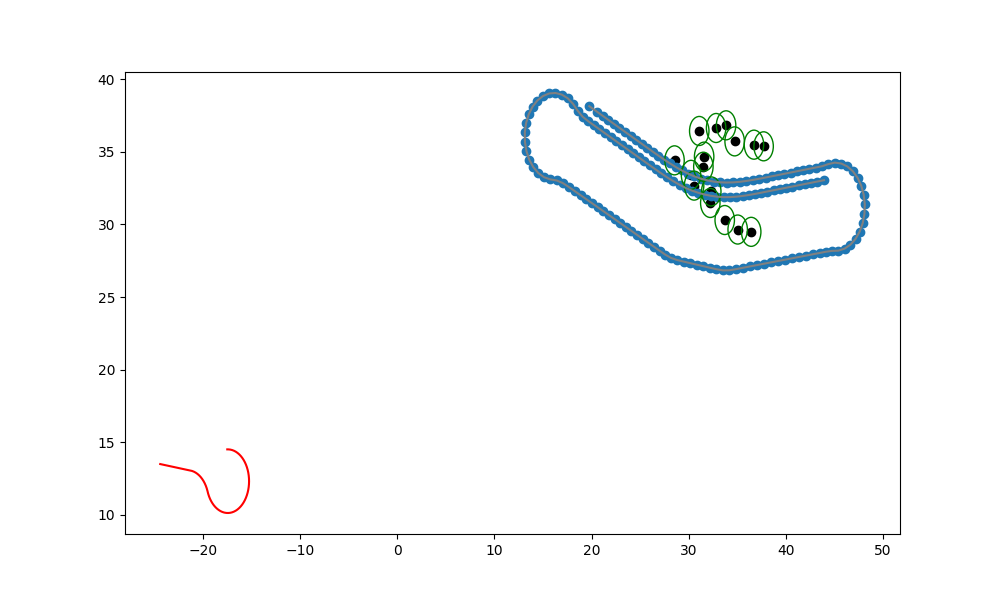

In [58]:
obstacles_full = make_points_from_relative_data([(0.01, 0.5, 0),
                                            #(3.1, -0.8),
                                            (1.0,-1.9),
                                             (1.0, -2.6),
                                             (-1.0, -5.0),
                                             (-2,-4),
                                             (0, -4.7),
                                              #(2,-4),
                                            (4,-2),
                                           (0,-0.3),
                                          (-1.6,1.5),
                                           (-3,2),
                                           (-5,-4),
                                           (1.7,-4.3),
                                           ( -4, -4),
                                            (-4.4,2),
                                            (2.2,-1.2),
                                            (1.8,-0.5),
                                           ], spline[18])

obstacles_full = obstacles_full[:]
obstacles_full = np.array(obstacles_full)
fig = plt.figure(figsize = (10,6))
ax = plt.axes()

draw_obstacles(ax, obstacles_full, min_obstcle_avoid_radius)
ax.plot(x_line, y_line, 'gray')
ax.plot(data[:,0], data[:,1], 'r')
ax.scatter(x_line, y_line, cmap='Greens')